In [1]:
# https://stackoverflow.com/questions/45350891/fitting-a-polynomial-using-np-polyfit-in-3-dimensions
# https://math.stackexchange.com/questions/1786495/estimating-the-curvature-of-a-discretized-curve-in-3d-with-cubic-splines

In [191]:
# %matplotlib qt
%load_ext autoreload
%autoreload 2
from utils.utils_IO import load_object, reshape_trial_dframe, write_video_from_directory, write_video_from_list, read_frame_at_idx, plot_chin_spline
from utils.polyfitting import fit_3D_polynomial, \
        fit_polynomials_per_frame, \
        eval_3D_polynomials, \
            eval_polynomials_per_frame, compute_curvature_per_frame, compute_curvature_function 
import numpy as np
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
import cv2
from pathlib import Path
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from tqdm import tqdm
import re
from typeguard import typechecked
from typing import List, Callable, Tuple
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [240]:
@typechecked
def make_empty_hierarchical_dict(unique_names: list, unique_conds: list)-> dict:
    trial_dict = {}
    for name in unique_names:
        trial_dict[name] = {}
        for cond in unique_conds:
            trial_dict[name][cond] = []
    return trial_dict

In [4]:
data_dict = load_object('/Volumes/sawtell-locker/C1/free/3d_reconstruction/V2/data_dict')

As a first pass, we analyze one trial [0] of one fish ['Joao'] of one condition ['pre'].

TODO: run for all trials.

In [8]:
trial_number = 0
example_trial = data_dict["trials"]["Joao"]["pre"][trial_number]
video_path = Path(data_dict["video_paths"]["Joao"]["pre"]) / "concatenated_tracking.avi"
#reproj_path = Path(f'/Volumes/sawtell-locker/C1/free/3d_reconstruction/V2/{video_path.parent.stem}') / "reprojections.mov"
#if not Path.is_file(reproj_path):
#    raise ValueError(f"No reprojections for {video_path.parent.stem}")

In [32]:
chin_trial_df.columns

MultiIndex([('chin_base', 'x'),
            ('chin_base', 'y'),
            ('chin_base', 'z'),
            ( 'chin_1_4', 'x'),
            ( 'chin_1_4', 'y'),
            ( 'chin_1_4', 'z'),
            ( 'chin_mid', 'x'),
            ( 'chin_mid', 'y'),
            ( 'chin_mid', 'z'),
            ( 'chin_3_4', 'x'),
            ( 'chin_3_4', 'y'),
            ( 'chin_3_4', 'z'),
            ( 'chin_end', 'x'),
            ( 'chin_end', 'y'),
            ( 'chin_end', 'z')],
           )

In [104]:
from utils.polyfitting import filter_coordinates

In [142]:
filtered_arr = filter_coordinates(np.asarray(chin_trial_df), coordinate_dims=3, medfilt_kernel_size=1)

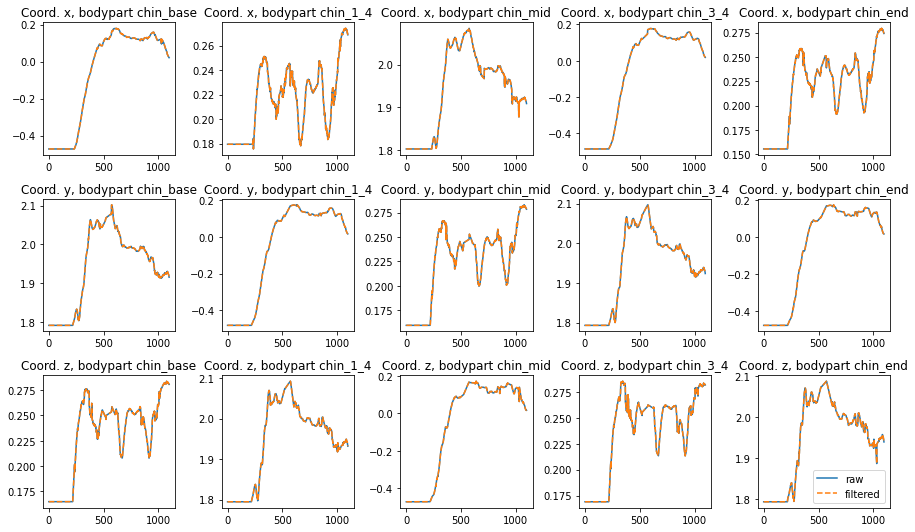

In [143]:
# TODO: doesn't look promising, ignore
num_rows = 3 # xyz coords
num_cols = filtered_arr.shape[1]//num_rows # body parts
dim_names = ['x', 'y', 'z']

fig, ax = plt.subplots(num_rows, 
                       num_cols, figsize = (12.5, 7.5))
for i in range(num_rows): # (x,y,z) dim
    for j in range(num_cols): # 2, 1, 0 order terms (or opposite)
        base_index = i*num_cols
        ax[i,j].plot(np.asarray(chin_trial_df)[:, base_index + j], label = "raw")
        ax[i,j].plot(filtered_arr[:, base_index + j], label = "filtered", linestyle = "dashed")
        ax[i,j].set_title("Coord. %s, bodypart %s" % (dim_names[i],bp_names[j]))
fig.tight_layout()
ax[-1,-1].legend()

In [192]:
chin_trial_arr, bp_names = reshape_trial_dframe(example_trial)

In [193]:
# # Collect columns with chin 
# # chin_base, chin_1_4, chin_mid, chin_3_4, chin_end
# chin_trial_df = example_trial.filter(regex='chin')
# chin_trial_arr = np.reshape(chin_trial_df.values, (chin_trial_df.values.shape[0], -1, 3))
# # Get bodypart names
# bp_names = []
# for col in chin_trial_df.columns:
#     if col[0] not in bp_names:
#         bp_names.append(col[0])

In [10]:
# fit polynomial to a sequence of time pts
coeffs_all_frames = fit_polynomials_per_frame(data_arr = chin_trial_arr, degree = 2)

100%|██████████| 1098/1098 [00:00<00:00, 5008.71it/s]


In [11]:
interpolation_points = np.linspace(0,4,20)

In [12]:
evals = eval_polynomials_per_frame(coeffs_all_frames, interpolation_points)

100%|██████████| 1098/1098 [00:00<00:00, 12829.98it/s]


In [330]:
curvatures = compute_curvature_per_frame(coeffs_all_frames=coeffs_all_frames, 
                                         interpolation_points=interpolation_points)

  0%|          | 0/1261 [00:00<?, ?it/s]/Users/danbiderman/Dropbox/Columbia/1.Dan/Research/mormyrid-control/mrmrd_ctrl/utils/polyfitting.py:27: RuntimeWarning: invalid value encountered in true_divide
  return numerator / denominator
100%|██████████| 1261/1261 [00:00<00:00, 32278.05it/s]


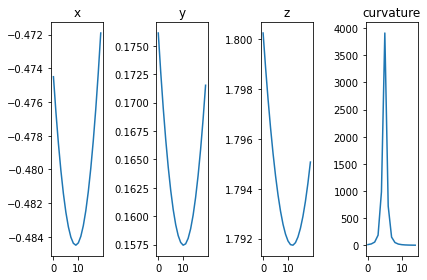

In [15]:
%matplotlib inline
frame_idx = 120
plt.subplot(141)
plt.plot(evals[frame_idx, 0, :])
plt.title('x')
plt.subplot(142)
plt.plot(evals[frame_idx, 1, :])
plt.title('y')
plt.subplot(143)
plt.plot(evals[frame_idx, 2, :])
plt.title('z')
plt.subplot(144)
plt.plot(curvatures[frame_idx, 5:])
plt.title('curvature')
plt.tight_layout()

In [16]:
from utils.utils_IO import plot_chin_spline
plot_chin_spline(chin_trial_arr=chin_trial_arr, bp_names=bp_names, 
                 poly_evals=evals, curvatures=curvatures, out_file="chin_movie.mov",
                 start_frame=500, end_frame=800)

100%|██████████| 300/300 [00:15<00:00, 19.75it/s]


Analyze and plot the coefficients of the polynomial in time.

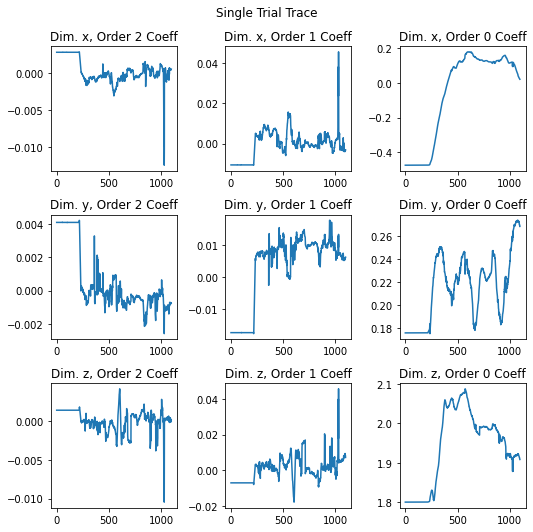

In [145]:
order = 2
dim_names = ['x', 'y', 'z']
fig, ax = plt.subplots(coeffs_all_frames.shape[1], 
                       coeffs_all_frames.shape[2], figsize = (7.5, 7.5))
fig.suptitle('Single Trial Trace')
for i in range(coeffs_all_frames.shape[1]): # (x,y,z) dim
    for j in range(coeffs_all_frames.shape[2]): # 2, 1, 0 order terms (or opposite)
        ax[i,j].plot(coeffs_all_frames[:, i, j])
        ax[i,j].set_title("Dim. %s, Order %i Coeff" % (dim_names[i],order-j))
fig.tight_layout()

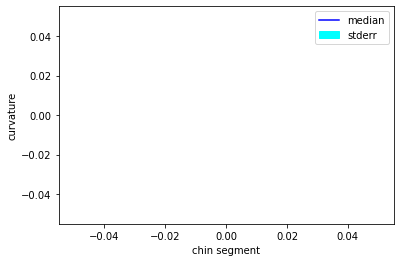

In [329]:
from utils.utils_IO import plot_trial_curvature
fig = plot_trial_curvature(curvatures, central_moment="median")

In [238]:
# @typechecked
# def get_hdi(arr: np.ndarray, alpha: float = 0.05)->tuple([np.ndarray, np.ndarray]):
#     sorted_arr = np.sort(arr)
#     inds = np.arange(1, arr.shape[0]+1)
#     ind_min = np.argmin(abs(inds/len(inds)- alpha/2.)) # if two successive inds are equivalent, np.argmin by default will take the preceding one
#     ind_max = np.argmin(abs(inds/len(inds)- (1.-alpha/2.))) # TODO: check if we're losing one ind
#     print(ind_min)
#     print(ind_max)
#     print(sorted_arr[ind_min, :])
#     return sorted_arr[ind_min, :], sorted_arr[ind_max, :]
# test_arr = np.array([[1., 2., 3., 4.], [5., 6., 7., 8], [9., 10., 11., 12.]])
# print(test_arr)
# get_hdi(test_arr)
    

In [239]:
# test_arr = np.vstack([np.random.permutation(np.arange(100)), np.random.permutation(2*np.arange(100))]).T
# print(test_arr.shape)
# get_hdi(test_arr)

(100, 2)
2
96
[ 25 186]


(array([ 25, 186]), array([21, 90]))

In [175]:
# loop over conditions. loop over trials. compute average curvature per condition across trials and time points
accel_dict = make_empty_hierarchical_dict(fish_names, cond_names)

for i, fish in enumerate(data_dict["trials"].keys()):
    for j, cond in enumerate(data_dict["trials"][fish].keys()):
        #beta_dict[fish][cond] = np.zeros((15, 15, len(data_dict["trials"][fish][cond])))
        for k, trial_dframe in enumerate(data_dict["trials"][fish][cond]):

In [243]:
interpolation_points = np.linspace(0,4,20) # chin has 5 segments thus (0,1,2,3,4)
fish_names = ["Joao", "Greg", "Neil"]
cond_names = ["pre", "post"]
curvature_dict = make_empty_hierarchical_dict(fish_names, cond_names)
for i, fish in enumerate(data_dict["trials"].keys()):
    for j, cond in enumerate(data_dict["trials"][fish].keys()):
        for k, trial_dframe in enumerate(data_dict["trials"][fish][cond]):
            chin_trial_arr, bp_names = reshape_trial_dframe(trial_dframe)
            # fit polynomial to a sequence of time pts
            coeffs_all_frames = fit_polynomials_per_frame(data_arr = chin_trial_arr, degree = 2)
            # make polynomial predictions
            evals = eval_polynomials_per_frame(coeffs_all_frames, interpolation_points)
            # compute curvatures
            curvatures = compute_curvature_per_frame(coeffs_all_frames=coeffs_all_frames, 
                                             interpolation_points=interpolation_points)
            # save
            curvature_dict[fish][cond].append(curvatures)
            

100%|██████████| 1135/1135 [00:00<00:00, 49839.66it/s]


100%|██████████| 1234/1234 [00:00<00:00, 5447.11it/s]


100%|██████████| 705/705 [00:00<00:00, 49128.32it/s]


100%|██████████| 593/593 [00:00<00:00, 5410.78it/s]


100%|██████████| 559/559 [00:00<00:00, 49464.47it/s]


100%|██████████| 1261/1261 [00:00<00:00, 49233.59it/s]


In [323]:
@typechecked
def summarize_curvature(curvature_arr: np.ndarray)->tuple([np.ndarray, np.ndarray, np.ndarray]):
    mean = np.nanmean(curvature_arr, axis = 0)
    med = np.nanmedian(curvature_arr, axis = 0)
    maximum = np.nanmax(curvature_arr, axis = 0)
    stderr = np.nanstd(curvature_arr, axis = 0)/np.sqrt(curvature_arr.shape[0])
    return mean, med, maximum, stderr

In [324]:
total_mean_curvature_dict = make_empty_hierarchical_dict(fish_names, cond_names)
total_stderr_curvature_dict = make_empty_hierarchical_dict(fish_names, cond_names)

In [327]:
for i, fish in enumerate(curvature_dict.keys()):
    print(fish)
    for j, cond in enumerate(curvature_dict[fish].keys()):
        print(cond)
        cond_arr = np.zeros((len(curvature_dict[fish][cond]), len(interpolation_points)))
        for k, trial_curvature in enumerate(curvature_dict[fish][cond]):
            mean, med, maximum, stderr = summarize_curvature(trial_curvature)
            cond_arr[k, :] = med # TODO: choose mean, med or maximum 
        total_mean_curvature_dict[fish][cond] = np.median(cond_arr, axis=0) # here too:  TODO: choose mean, med or maximum
        total_stderr_curvature_dict[fish][cond] = np.std(cond_arr, axis=0)/np.sqrt(cond_arr.shape[0])

Joao
pre
post
Greg
pre
post
Neil
pre
post


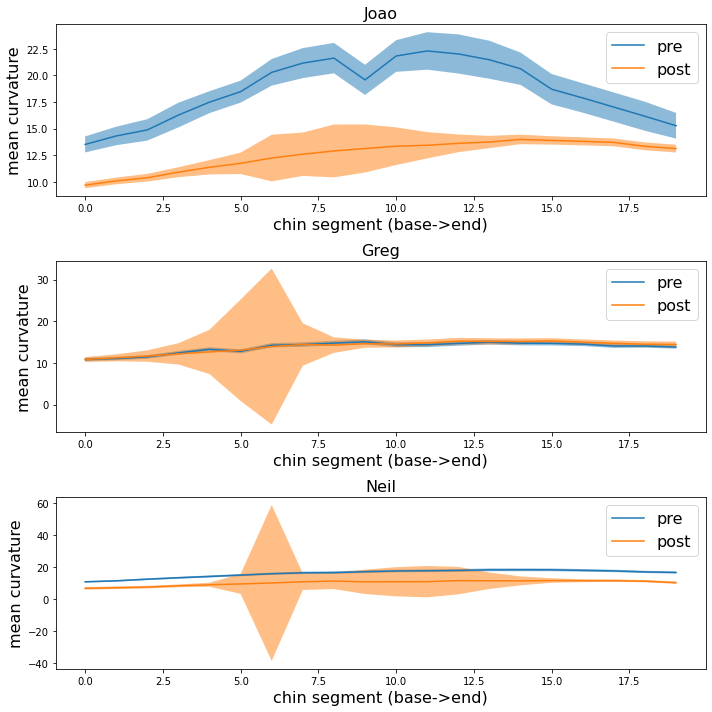

In [328]:
fig, ax = plt.subplots(len(fish_names), 1, figsize = (10, 10))
for i, fish in enumerate(curvature_dict.keys()):
    for j, cond in enumerate(curvature_dict[fish].keys()):
        ax[i].plot(np.arange(curvatures.shape[1]), total_mean_curvature_dict[fish][cond], label = cond);
        ax[i].fill_between(np.arange(curvatures.shape[1]), total_mean_curvature_dict[fish][cond]-total_stderr_curvature_dict[fish][cond], 
                           total_mean_curvature_dict[fish][cond]+total_stderr_curvature_dict[fish][cond], alpha=0.5)
    ax[i].set_title(fish, fontsize=16)
    ax[i].set_xlabel('chin segment (base->end)', fontsize=16)
    ax[i].set_ylabel('mean curvature', fontsize=16)
    ax[i].legend(fontsize=16)
fig.tight_layout()
fig.savefig('curvatures.png')

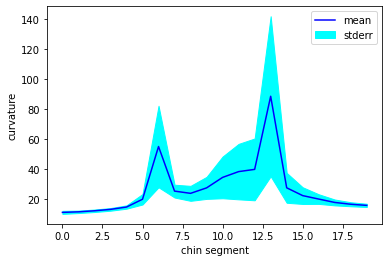

In [300]:
fig = plot_trial_curvature(cond_arr, central_moment="mean")